In [21]:
%matplotlib inline
import msprime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import SVG


In [39]:
population_configurations = [
    msprime.PopulationConfiguration(sample_size=2),
    msprime.PopulationConfiguration(sample_size=2)]
theta = 2
rho = 1

def run_simulation(m, num_replicates=1):
    migration_matrix = [[0, m], [m, 0]]
    replicates = msprime.simulate(
        population_configurations=population_configurations,
        migration_matrix=migration_matrix,
        num_replicates=num_replicates, 
        mutation_rate=theta / 4,
        recombination_rate=rho / 4)
    data = np.zeros((num_replicates, 3, 3))
    for rep_index, ts in enumerate(replicates):
        for tree in ts.trees(tracked_samples=[0, 1]):            
            for site in tree.sites():
                for mutation in site.mutations:                    
                    nleaves0 = tree.num_tracked_samples(mutation.node)
                    nleaves1 = tree.num_samples(mutation.node) - nleaves0                
                    data[rep_index, nleaves0, nleaves1] += 1            
    return data       

true_m = 0.2
truth = run_simulation(true_m, num_replicates=20)
truth_mean = np.mean(truth, axis=0)
print("truth =")
print(truth_mean)


truth =
[[ 0.    1.95  1.8 ]
 [ 2.1   0.35  1.15]
 [ 1.85  0.6   0.  ]]


In [46]:
num_replicates = 1000
prior_m = np.random.exponential(0.1, num_replicates)
distance = np.zeros(num_replicates)
for j in range(num_replicates):
    data = run_simulation(prior_m[j], num_replicates=20)
    data_mean = np.mean(data, axis=0)
    # Compute the Euclidean distance
    distance[j] = np.sqrt(np.sum(data_mean - truth_mean)**2)
    


[  1.65000000e+00   1.82500000e+01   2.03500000e+01   1.01500000e+01
   4.80000000e+00   5.50000000e-01   6.06500000e+01   1.00000000e-01
   6.60000000e+00   3.00000000e-01   3.35000000e+00   9.90000000e+00
   2.05000000e+00   5.95000000e+00   7.31000000e+01   2.50000000e-01
   1.00000000e-01   2.80000000e+00   1.79000000e+01   1.00000000e+00
   8.97500000e+01   4.15000000e+00   3.60000000e+01   2.85000000e+00
   4.40000000e+00   7.10000000e+00   1.55000000e+00   3.60500000e+01
   5.00000000e-02   1.09000000e+01   9.00000000e-01   2.65000000e+00
   4.60000000e+00   6.95000000e+00   5.50000000e+00   2.83000000e+01
   6.85000000e+00   4.85000000e+00   4.75000000e+00   3.30000000e+00
   2.40500000e+01   1.15000000e+00   1.55000000e+00   1.11022302e-16
   1.20000000e+00   3.45000000e+00   6.26000000e+01   9.55000000e+00
   2.51500000e+01   2.95500000e+01   1.45000000e+00   1.34500000e+01
   1.54500000e+01   1.66500000e+01   5.00000000e-01   2.95000000e+00
   2.60000000e+00   3.90000000e+00

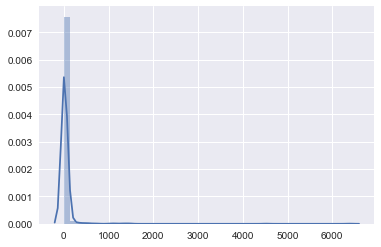

In [47]:
sns.distplot(distance)

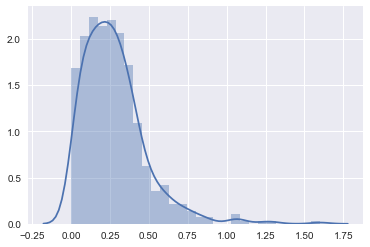

In [52]:
cutoff = np.percentile(distance, 50)
keep = np.where(distance < cutoff)

weighted_prior = prior_m[keep] * distance[keep]

sns.distplot(weighted_prior)